In [1]:
# import necessary libraries
import hndlRas
import mbUtils
import warpRas
import geopandas as gpd
import rasterio
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
# download raster files from google drive based on the blob id
# make sure that this folder's permissions are public (see hndlRas.py)
# define starting and ending slice of string indices representing
# the date in YYYYMMDD format

# if files are already downloaded from previous runs
if len(glob.glob('*.tif')) > 1:
    files = hndlRas.readTif(stSlice = 0, enSlice = 8)
    
# if need to download
else:
    files = hndlRas.arrTif('1Tdq2LA4UV5S5HTL8oBzhoRry1V1wK6nk',stSlice = 0,\
                    enSlice = 8)
# visualize output file structure and corresponding dates
files

,fname,time
0,20090604_1939_1020010008A18900_1020010008C45D0...,2009-06-04
1,20140823_1932_10200100324CCF00_10200100341F530...,2014-08-23
2,20150818_1939_104001000F1D3000_1040010010D7CB0...,2015-08-18
3,20130603_1915_10200100236DC700_1020010021A8860...,2013-06-03
4,20111027_1926_1050410002BB0C00_1050410002BDA50...,2011-10-27
5,20160507_2209_102001004F892100_10200100503E1A0...,2016-05-07
6,20080926_1926_1020010004796700_1020010004B32D0...,2008-09-26
7,20120901_1921_10504100007F0300_105041000077540...,2012-09-01
8,20150309_2026_1020010038BBD000_102001003AD5FD0...,2015-03-09


In [3]:
# download shapefile for clip
glacShp = 'GlacOutline/OLYGlac_Output.shp'

In [4]:
# define array indicating rasters of interest
# use files pandas dataframe indices!
z1 = [6,7,3,1,2]
z2 = [0,3,1,2,5]

In [5]:
# read outline into geopandas and sort by decreasing size
glacOutline = gpd.read_file(glacShp).sort_values(['Area_1'],ascending = False).reset_index(drop=True)

In [6]:
# define initial glacier class to be performed for each glacier outline
class GlacFeat:
    def __init__(self):
        self.z1 = None
        self.z2 = None
        self.dz = None
        self.dzdt = None

In [7]:
# this is temporary until I figure out a better way
# probably using xarray??
datacube = np.random.randn(430,389,len(z1))
datacubedt = np.random.randn(430,389,len(z1))

# instantiate rasterio object
# catchall for rerun if the loop below fails
dem1 = None
dem2 = None

# for each pair of DEMs
for i in range(0,len(z1)):
    featCount = 0
    # warp DEMs to a common reference DEM
    warpRas.warpDEMs(files['fname'][z1[0]],\
                     files['fname'][z1[i]],'newz1.tif')
    warpRas.warpDEMs(files['fname'][z1[0]],\
                     files['fname'][z2[i]],'newz2.tif')
    
    # open warped DEMs
    dem1 = rasterio.open('newz1.tif')
    dem2 = rasterio.open('newz2.tif')
    
    # for each glacier feature
    for feat in enumerate(glacOutline['geometry']):
        if featCount < 1:
            
            #instantiate a glacier object and perform surface change obs
            gf = GlacFeat()
            mbUtils.clip(gf,dem1,dem2,feat)
            mbUtils.surfdz(gf,files['time'][z1[i]],files['time'][z2[i]])

            #temporary
            datacube[:,:,i] = gf.dz
            datacubedt[:,:,i] = gf.dzdt
        else:
            break
        
        # iterate feature count
        featCount += 1
        
    # reset rasterio objects
    dem1 = None
    dem2 = None
    os.remove('newz1.tif')
    os.remove('newz2.tif')

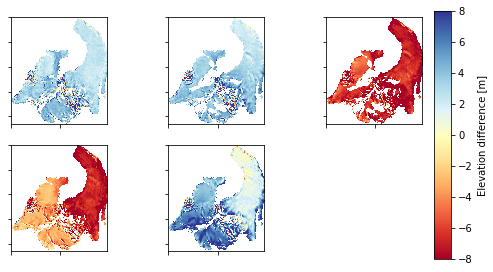

In [8]:
# Elevation-change maps for each year
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
ax1.imshow(datacube[:,:,0],vmin=-8,vmax=8,cmap='RdYlBu')
ax2.imshow(datacube[:,:,1],vmin=-8,vmax=8,cmap='RdYlBu')
ax3.imshow(datacube[:,:,2],vmin=-8,vmax=8,cmap='RdYlBu')
ax4.imshow(datacube[:,:,3],vmin=-8,vmax=8,cmap='RdYlBu')
sm = ax5.imshow(datacube[:,:,4],vmin=-8,vmax=8,cmap='RdYlBu')
ax1.tick_params(labelleft=False,labelbottom=False)
ax2.tick_params(labelleft=False,labelbottom=False)
ax3.tick_params(labelleft=False,labelbottom=False)
ax4.tick_params(labelleft=False,labelbottom=False)
ax5.tick_params(labelleft=False,labelbottom=False)
f.delaxes(ax6)
#plt.tight_layout()
cbaxes = f.add_axes([0.89, 0.1, 0.03, 0.8]) 
cb = plt.colorbar(sm, cax = cbaxes)  
cb.ax.set_ylabel('Elevation difference [m]')
f.set_size_inches(8,4.3)

plt.savefig('spatialDiff.png')

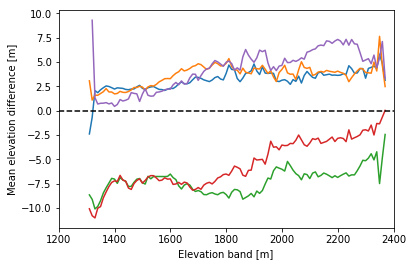

In [9]:
# average annual elevation losses binned by elevation
bins = range(1000,2500,10)
for i in range(0,len(z1)):
    mb = mbUtils.binbyElev(gf.z1[0][0],datacube[:,:,i],bins)
    mb['mean'].values[mb['mean'].values > 10] = np.nan
    plt.plot(bins[0:149],mb['mean'].values)

plt.plot([bins[0],bins[149]],[0,0],'--k')
plt.ylabel('Mean elevation difference [m]')
plt.xlabel('Elevation band [m]')
plt.xlim(1200,2400)

plt.savefig('binnedDiff.png')

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median for 102061 results
  r = func(a, **kwargs)


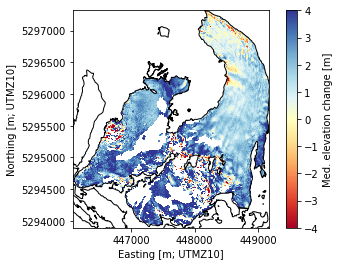

In [24]:
# median glacier elevation change
medStack = np.median(datacube,axis=2)

WV = glacOutline['geometry'][0]
extent = [WV.bounds[0],WV.bounds[2],WV.bounds[1],WV.bounds[3]]

#plt.subplots(figsize=(14,6))
glacOutline['geometry'].plot(facecolor='None',edgecolor='black')
plt.imshow(medStack,vmin=-4,vmax=4,cmap='RdYlBu',extent = extent)
c = plt.colorbar()
plt.ylabel('Northing [m; UTMZ10]')
plt.xlabel('Easting [m; UTMZ10]')
c.ax.set_ylabel(ylabel='Med. elevation change [m]')

plt.savefig('medDiff.png')

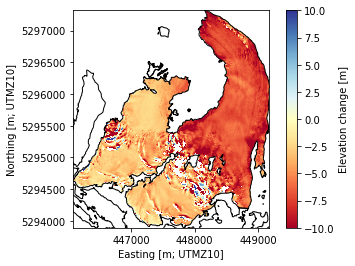

In [21]:
# WY2015 elevation changes
WV = glacOutline['geometry'][0]
extent = [WV.bounds[0],WV.bounds[2],WV.bounds[1],WV.bounds[3]]
glacOutline['geometry'].plot(facecolor='None',edgecolor='black')
plt.imshow(datacube[:,:,3],vmin=-10,vmax = 10,cmap='RdYlBu',extent = extent)
c = plt.colorbar()
plt.ylabel('Northing [m; UTMZ10]')
plt.xlabel('Easting [m; UTMZ10]')
c.ax.set_ylabel(ylabel='Elevation change [m]')

plt.savefig('2015diff.png')